## MAIN MODEL

In [1]:
# Core libraries
import pandas as pd  
import numpy as np   
import os
import shutil
import json

%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Preprocessing tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import  Input , Conv2D, MaxPooling2D, Flatten, Dense , Dropout, BatchNormalization , concatenate, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import itertools
from tensorflow.keras import layers, optimizers



2025-07-29 16:45:51.094072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753807551.283489      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753807551.342359      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
metadata_csv = '/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv'
image_dir = '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer'
output_dir = '/kaggle/working/skin_cancer_split'

In [10]:
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Filter out missing files (in case)
df = df[df['image_path'].apply(os.path.exists)]

In [11]:
df_train, df_temp = train_test_split(df, test_size=0.30, stratify=df['dx'], random_state=42)


df_val, df_test = train_test_split(df_temp, test_size=0.50, stratify=df_temp['dx'], random_state=42)

# Check splits
print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")


Train: 7010, Val: 1502, Test: 1503


In [12]:
def copy_images(df_subset, subset_name):
    for _, row in df_subset.iterrows():
        class_name = row['dx']
        src_path = row['image_path']
        dst_dir = os.path.join(output_dir, subset_name, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

In [13]:
# Copy files to folders
copy_images(df_train, 'train')
copy_images(df_val, 'val')
copy_images(df_test, 'test')

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/skin_cancer_split/train',
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/skin_cancer_split/val',
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/skin_cancer_split/test',
    image_size=(224, 224),
    batch_size=32
)

Found 7010 files belonging to 7 classes.


I0000 00:00:1753807703.020464      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1502 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.


In [16]:
# Get true labels from train_ds
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())
y_train = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.115440115440116}


## Model Selection

After runnning our base model, we decided to go ahead with transfer learning. There are two models that we considered as they were pretrained on millions of image data. These are MobileNetV2 and EfficientNetB1. To get the best out of these models, we used and Ensemble model at the end setting the weight of EfficientNetB1 to 0.6 and that of MobileNetV2 to 0.4 depending on their individual performances.

## Transfeer Learning

In [17]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,   
    weights='imagenet'
)
base_model.trainable = False  

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
# Load base model without top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze top layers for fine-tuning
base_model.trainable = True
fine_tune_at = 125  # From 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
# Input layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Data augmentation
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.RandomContrast(0.1)(x)

# Preprocess for MobileNetV2
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# Pass through base model
x = base_model(x, training=False)

# Custom classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Assemble model
model = models.Model(inputs, outputs)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 1,690,951 (6.45 MB)

 Non-trainable params: 731,904 (2.79 MB)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("finetuned_model.keras", save_best_only=True),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,        # reduce LR by half
        patience=2,        # wait 2 epochs after plateau
        min_lr=1e-6,
        verbose=1
    )
]

#Added call back

## Hyperparameter Tuning

To implement hyperparameter tuning, we used various methods and varied some parameters to achieve our best possible model. Some of the parameters include:

- Dropout rates or adding batch normalization  
- Learning rate (LR)  
- Batch size  
- Number of epochs  
- Data augmentation (flip type and rotational range)  
- Unfreezing layers in transfer learning


**Changing from Sparse categorical crossentropy to Focal loss with Class weight**

In [109]:
def focal_loss_with_class_weights(class_weights, gamma=2.):
    class_weights = tf.constant(class_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])
        
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred)
        probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
        class_alphas = tf.gather(class_weights, y_true)
        focal_weight = tf.pow(1. - probs, gamma)
        
        loss = class_alphas * focal_weight * cross_entropy
        return loss
    
    return loss

In [110]:
# Collect labels from train_ds
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())
y_train = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.115440115440116}


In [111]:
# Convert class_weights dict to ordered list
class_weights_list = [class_weights[i] for i in range(len(class_weights))]


focal = focal_loss_with_class_weights(class_weights_list, gamma=2.0)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=focal,
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.0985 - loss: 1.7916 - val_accuracy: 0.2730 - val_loss: 1.3837 - learning_rate: 1.0000e-05
Epoch 2/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.2893 - loss: 1.2292 - val_accuracy: 0.4334 - val_loss: 1.1097 - learning_rate: 1.0000e-05
Epoch 3/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.3658 - loss: 1.0643 - val_accuracy: 0.5513 - val_loss: 0.9708 - learning_rate: 1.0000e-05
Epoch 4/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.4379 - loss: 0.9477 - val_accuracy: 0.5752 - val_loss: 0.8570 - learning_rate: 1.0000e-05
Epoch 5/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.4552 - loss: 0.8610 - val_accuracy: 0.6099 - val_loss: 0.7896 - learning_rate: 1.0000e-05
Epoch 6/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.4907 - loss: 0.7859 - val_accuracy: 0.6318 - val_loss: 0.7378 - learning_rate: 1.0000e-05
Epoch 7/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/ste

In [33]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6581 - loss: 0.5861
Test Accuracy: 0.6547


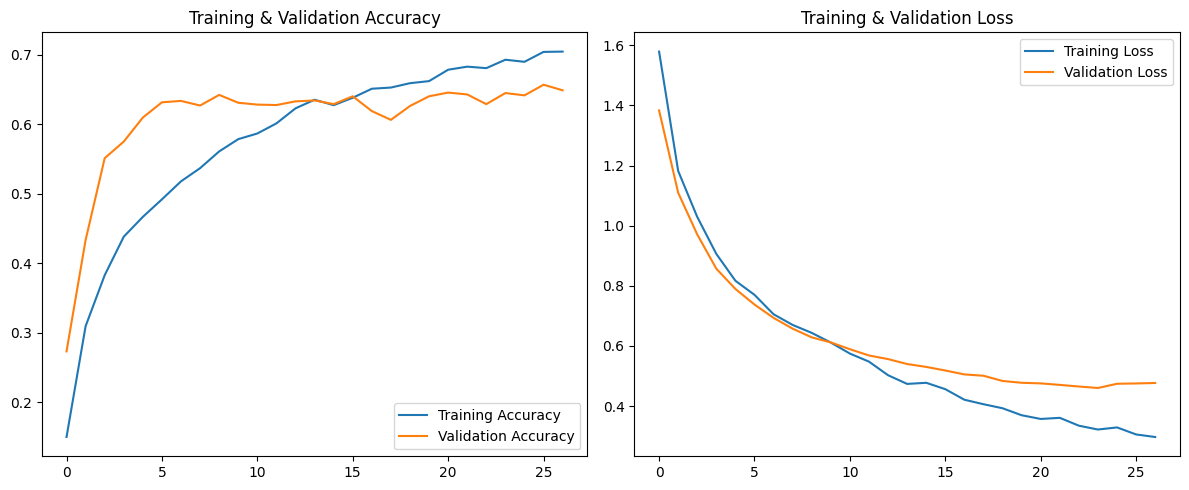

In [35]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Evaluation Metrics

To evaluate the model performance, we used the following metrics:

- **Test Accuracy and Loss**: These provide a general sense of how well the model performs on unseen data. Accuracy indicates the proportion of correct predictions, while loss reflects how confident and calibrated the model is in its predictions.

- **Confusion Matrix**: This helps visualize how well the model distinguishes between individual classes by showing true positives, false positives, false negatives, and true negatives for each class.

- **F1 Score**: This metric balances precision and recall, making it especially useful since we have an imbalance class. It ensures that the model performs well not just in terms of overall accuracy but also in handling each class fairly.

We chose these metrics to get a comprehensive understanding of both overall model performance and class-level behavior, especially since our task is  multi-class classification  where accuracy alone can be misleading.


In [36]:
# Collect predictions and labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

In [37]:
print(" F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

 F1 Scores:
Macro F1: 0.5136334708917205
Micro F1: 0.654690618762475
Weighted F1: 0.691551228504235

 Classification Report:
              precision    recall  f1-score   support

       akiec       0.48      0.51      0.50        49
         bcc       0.64      0.47      0.54        77
         bkl       0.36      0.66      0.47       165
          df       0.12      0.53      0.20        17
         mel       0.34      0.54      0.42       167
          nv       0.95      0.69      0.80      1006
        vasc       0.62      0.73      0.67        22

    accuracy                           0.65      1503
   macro avg       0.50      0.59      0.51      1503
weighted avg       0.77      0.65      0.69      1503



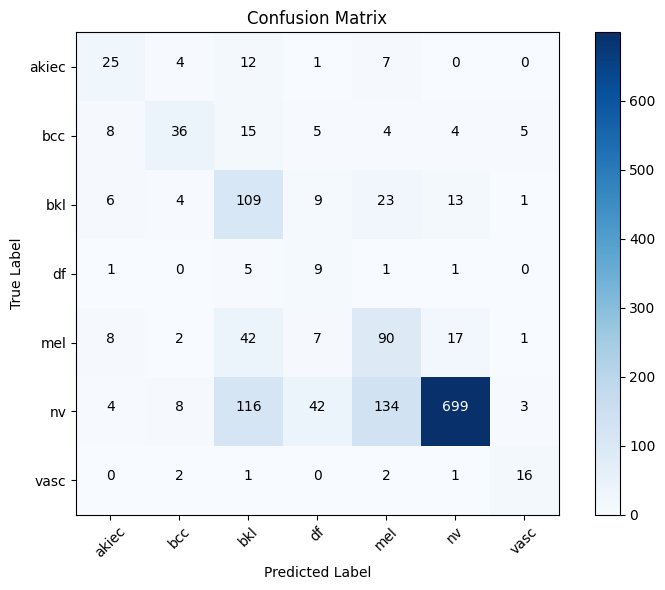

In [38]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

In [39]:
model.save("baseline_mobilenetv2_focal.keras")

# Proceeding to EfficientNetB1

In [112]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import layers, models, optimizers, callbacks

In [113]:
# Load EfficientNetB1 base (exclude top classifier)
base_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # freeze initially

In [114]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

In [115]:
# Define full model
num_classes = 7
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

In [116]:
# Compile with focal loss + class weights (already converted to list)
focal = focal_loss_with_class_weights(class_weights_list, gamma=1.5)
model.compile(optimizer=optimizers.Adam(1e-4), loss=focal, metrics=['accuracy'])

In [117]:
# Initial training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("finetuned_model.keras", save_best_only=True),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,        # reduce LR by half
        patience=2,        # wait 2 epochs after plateau
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    callbacks=callbacks  
)

Epoch 1/80


E0000 00:00:1753819682.326298      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_21_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


220/220 ━━━━━━━━━━━━━━━━━━━━ 47s 113ms/step - accuracy: 0.1623 - loss: 1.6509 - val_accuracy: 0.3928 - val_loss: 1.4179 - learning_rate: 1.0000e-04
Epoch 2/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.3385 - loss: 1.4605 - val_accuracy: 0.5266 - val_loss: 1.2746 - learning_rate: 1.0000e-04
Epoch 3/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.4242 - loss: 1.2925 - val_accuracy: 0.5326 - val_loss: 1.1805 - learning_rate: 1.0000e-04
Epoch 4/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.4626 - loss: 1.1839 - val_accuracy: 0.5646 - val_loss: 1.1138 - learning_rate: 1.0000e-04
Epoch 5/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.5037 - loss: 1.1588 - val_accuracy: 0.5699 - val_loss: 1.0631 - learning_rate: 1.0000e-04
Epoch 6/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.5051 - loss: 1.1226 - val_accuracy: 0.5739 - val_loss: 1.0231 - learning_rate: 1.0000e-04
Epoch 7/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accur

**Fine Tuning the EfficientNetB1 Modde**

In [118]:

fine_tune_at = 25
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(optimizer=optimizers.Adam(1e-5), loss=focal, metrics=['accuracy'])

In [119]:
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    #initial_epoch=10,
    callbacks=callbacks
)

Epoch 1/80


E0000 00:00:1753820873.111276      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_21_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


220/220 ━━━━━━━━━━━━━━━━━━━━ 154s 354ms/step - accuracy: 0.1965 - loss: 1.4368 - val_accuracy: 0.3642 - val_loss: 1.1675 - learning_rate: 1.0000e-05
Epoch 2/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 315ms/step - accuracy: 0.2747 - loss: 1.2266 - val_accuracy: 0.4334 - val_loss: 1.1813 - learning_rate: 1.0000e-05
Epoch 3/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 70s 319ms/step - accuracy: 0.3226 - loss: 1.0959 - val_accuracy: 0.5020 - val_loss: 1.1140 - learning_rate: 1.0000e-05
Epoch 4/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 315ms/step - accuracy: 0.3791 - loss: 0.9923 - val_accuracy: 0.5546 - val_loss: 1.0560 - learning_rate: 1.0000e-05
Epoch 5/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 70s 316ms/step - accuracy: 0.4429 - loss: 0.9090 - val_accuracy: 0.5866 - val_loss: 0.9956 - learning_rate: 1.0000e-05
Epoch 6/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 315ms/step - accuracy: 0.4721 - loss: 0.8446 - val_accuracy: 0.6138 - val_loss: 0.9580 - learning_rate: 1.0000e-05
Epoch 7/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 315ms/step -

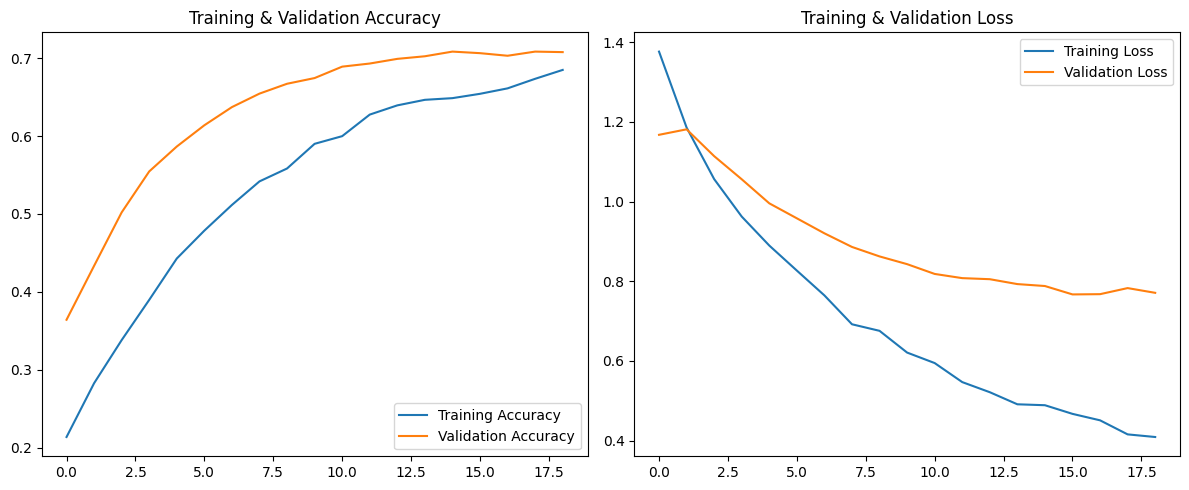

In [121]:
def plot_training_history(history):
    acc = fine_tune_history.history['accuracy']
    val_acc = fine_tune_history.history['val_accuracy']
    loss = fine_tune_history.history['loss']
    val_loss = fine_tune_history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [130]:
#Adjusting LR and gamma
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss_with_class_weights(class_weights_list, gamma=2.5),
    metrics=['accuracy']
)

In [131]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("finetuned_model.keras", save_best_only=True),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,        # reduce LR by half
        patience=2,        # wait 2 epochs after plateau
        min_lr=1e-6,
        verbose=1
    )
]

In [132]:
history_eff = model.fit(
    train_ds,
    validation_data=val_ds,
    #initial_epoch=30,
    epochs= 70,  
    callbacks=callbacks 
)

Epoch 1/70


E0000 00:00:1753823318.767474      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_21_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


220/220 ━━━━━━━━━━━━━━━━━━━━ 154s 344ms/step - accuracy: 0.6918 - loss: 0.3095 - val_accuracy: 0.7224 - val_loss: 0.6472 - learning_rate: 1.0000e-05
Epoch 2/70
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.6987 - loss: 0.2859 - val_accuracy: 0.7330 - val_loss: 0.6396 - learning_rate: 1.0000e-05
Epoch 3/70
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.7158 - loss: 0.2673 - val_accuracy: 0.7297 - val_loss: 0.6346 - learning_rate: 1.0000e-05
Epoch 4/70
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 315ms/step - accuracy: 0.7201 - loss: 0.2657 - val_accuracy: 0.7357 - val_loss: 0.6347 - learning_rate: 1.0000e-05
Epoch 5/70
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7099 - loss: 0.2453
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 314ms/step - accuracy: 0.7099 - loss: 0.2453 - val_accuracy: 0.7224 - val_loss: 0.6391 - learning_rate: 1.0000e-05
Epoch 6/70
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 316ms/step - accur

In [133]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7162 - loss: 0.5157
Test Accuracy: 0.7099


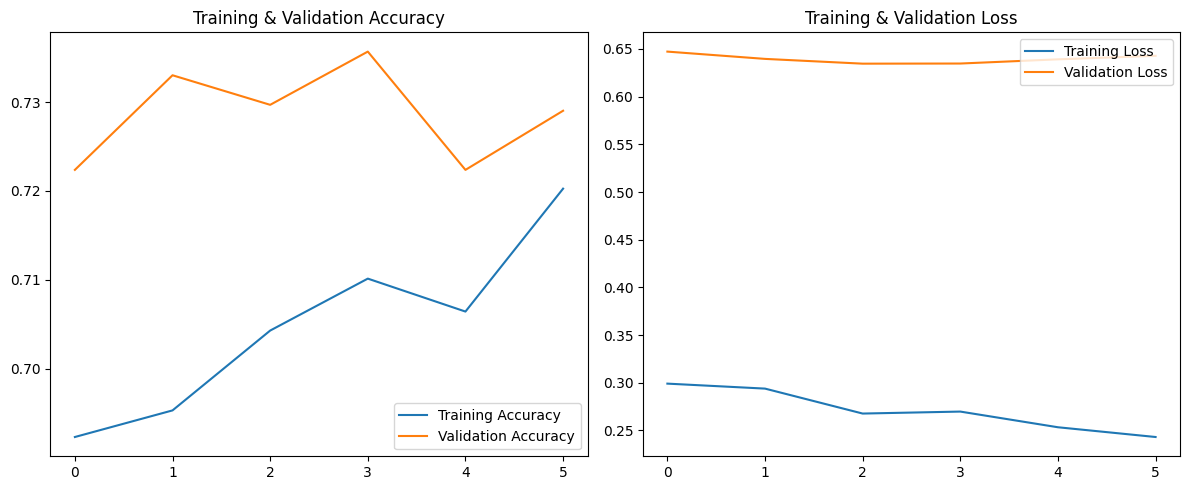

In [134]:
def plot_training_history(history):
    acc = history_eff.history['accuracy']
    val_acc = history_eff.history['val_accuracy']
    loss = history_eff.history['loss']
    val_loss = history_eff.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [135]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

# Metrics
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

Macro F1: 0.5432750306070535
Micro F1: 0.709913506320692
Weighted F1: 0.7293811279715259

Classification Report:
              precision    recall  f1-score   support

       akiec       0.56      0.29      0.38        49
         bcc       0.67      0.39      0.49        77
         bkl       0.41      0.67      0.51       165
          df       0.25      0.53      0.34        17
         mel       0.37      0.55      0.44       167
          nv       0.93      0.79      0.85      1006
        vasc       0.81      0.77      0.79        22

    accuracy                           0.71      1503
   macro avg       0.57      0.57      0.54      1503
weighted avg       0.78      0.71      0.73      1503



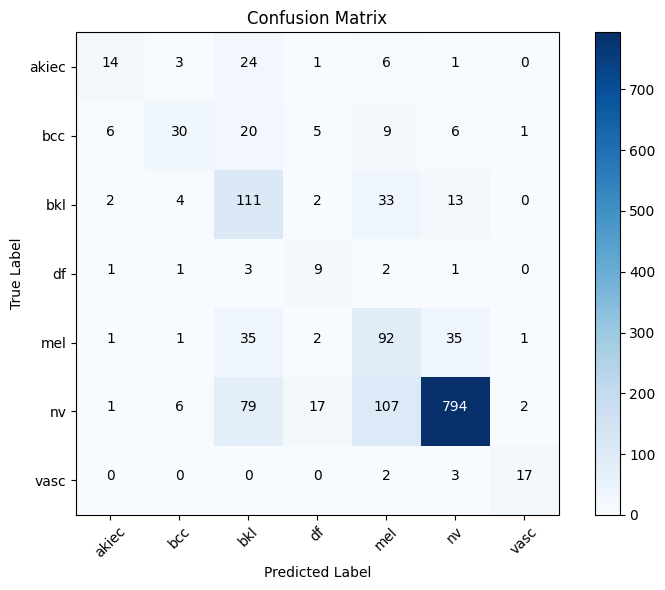

In [136]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

In [137]:
model.save("efficientnetb1_finetuned_best.keras")

**Final Ensemble Code (MobileNetV2 + EfficientNetB1)**

In [138]:
def focal_loss_with_class_weights(class_weights, gamma=2.0):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_onehot = tf.one_hot(y_true, depth=len(class_weights))
        cross_entropy = -y_true_onehot * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
        weights = tf.gather(class_weights, y_true)
        focal = weights * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))
    
    return loss

In [139]:
custom_loss = focal_loss_with_class_weights(class_weights_list, gamma=1.5)

# Load both models using the same custom_objects argument
mobilenet_model = tf.keras.models.load_model(
    "baseline_mobilenetv2_focal.keras",
    custom_objects={"loss": custom_loss}
)

efficientnet_model = tf.keras.models.load_model(
    "efficientnetb1_finetuned_best.keras",
    custom_objects={"loss": custom_loss}
)

In [140]:
# Get softmax predictions from both models
y_true = []
ensemble_preds = []

for images, labels in test_ds:
    mobilenet_probs = mobilenet_model.predict(images, verbose=0)
    efficientnet_probs = efficientnet_model.predict(images, verbose=0)

    avg_probs = (mobilenet_probs + efficientnet_probs) / 2.0
    preds = np.argmax(avg_probs, axis=1)

    ensemble_preds.extend(preds)
    y_true.extend(labels.numpy())  

ensemble_preds = np.array(ensemble_preds)
y_true = np.array(y_true)

In [141]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

       akiec       0.08      0.04      0.05        49
         bcc       0.13      0.08      0.10        77
         bkl       0.10      0.17      0.13       165
          df       0.06      0.12      0.08        17
         mel       0.12      0.18      0.14       167
          nv       0.67      0.56      0.61      1006
        vasc       0.00      0.00      0.00        22

    accuracy                           0.42      1503
   macro avg       0.17      0.16      0.16      1503
weighted avg       0.48      0.42      0.45      1503



In [142]:
class_names = test_ds.class_names

print("Ensemble Classification Report:")
print(classification_report(y_true, ensemble_preds, target_names=class_names))

# F1 scores
print("Macro F1:", f1_score(y_true, ensemble_preds, average='macro'))
print("Micro F1:", f1_score(y_true, ensemble_preds, average='micro'))
print("Weighted F1:", f1_score(y_true, ensemble_preds, average='weighted'))

Ensemble Classification Report:
              precision    recall  f1-score   support

       akiec       0.71      0.45      0.55        49
         bcc       0.73      0.48      0.58        77
         bkl       0.43      0.73      0.54       165
          df       0.30      0.59      0.40        17
         mel       0.39      0.58      0.47       167
          nv       0.95      0.79      0.86      1006
        vasc       0.74      0.77      0.76        22

    accuracy                           0.73      1503
   macro avg       0.61      0.63      0.59      1503
weighted avg       0.80      0.73      0.75      1503

Macro F1: 0.5935859976126397
Micro F1: 0.729208250166334
Weighted F1: 0.7498538956492337


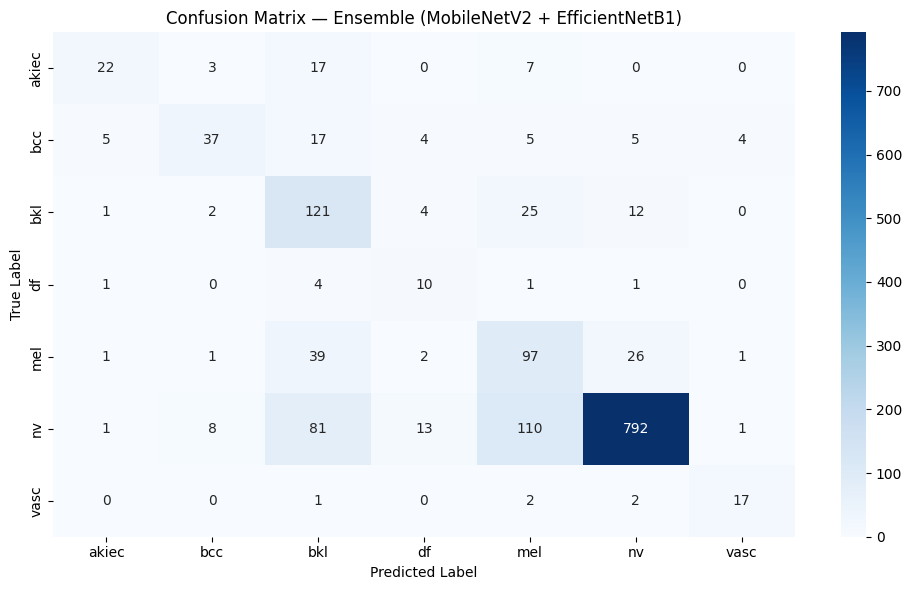

In [143]:
# Confusion matrix
cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Ensemble (MobileNetV2 + EfficientNetB1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

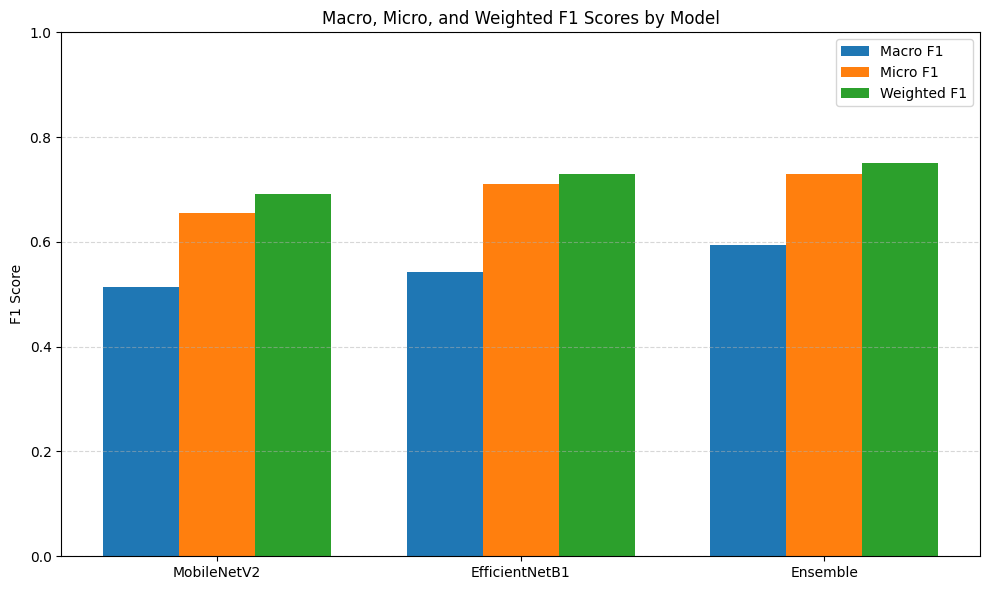

In [144]:
# Step 1: Define class names (from your dataset)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Step 2: Load both models
mobilenet_model = tf.keras.models.load_model("baseline_mobilenetv2_focal.keras", compile=False)
efficientnet_model = tf.keras.models.load_model("efficientnetb1_finetuned_best.keras", compile=False)

# Step 3: Run predictions
y_true = []
mobilenet_preds = []
efficientnet_preds = []
ensemble_preds = []

for images, labels in test_ds:
    labels_np = labels.numpy()
    y_true.extend(labels_np)

    mobilenet_probs = mobilenet_model.predict(images, verbose=0)
    efficientnet_probs = efficientnet_model.predict(images, verbose=0)

    mobilenet_pred = np.argmax(mobilenet_probs, axis=1)
    efficientnet_pred = np.argmax(efficientnet_probs, axis=1)

    avg_probs = (mobilenet_probs + efficientnet_probs) / 2.0
    ensemble_pred = np.argmax(avg_probs, axis=1)

    mobilenet_preds.extend(mobilenet_pred)
    efficientnet_preds.extend(efficientnet_pred)
    ensemble_preds.extend(ensemble_pred)

# Convert to arrays
y_true = np.array(y_true)
mobilenet_preds = np.array(mobilenet_preds)
efficientnet_preds = np.array(efficientnet_preds)
ensemble_preds = np.array(ensemble_preds)

# Step 4: Compute F1 scores dynamically
labels = ['MobileNetV2', 'EfficientNetB1', 'Ensemble']
f1_macro = [
    f1_score(y_true, mobilenet_preds, average='macro'),
    f1_score(y_true, efficientnet_preds, average='macro'),
    f1_score(y_true, ensemble_preds, average='macro')
]

f1_micro = [
    f1_score(y_true, mobilenet_preds, average='micro'),
    f1_score(y_true, efficientnet_preds, average='micro'),
    f1_score(y_true, ensemble_preds, average='micro')
]

f1_weighted = [
    f1_score(y_true, mobilenet_preds, average='weighted'),
    f1_score(y_true, efficientnet_preds, average='weighted'),
    f1_score(y_true, ensemble_preds, average='weighted')
]

# Step 5: Plot
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, f1_macro, width, label='Macro F1')
plt.bar(x, f1_micro, width, label='Micro F1')
plt.bar(x + width, f1_weighted, width, label='Weighted F1')

plt.xticks(x, labels)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("Macro, Micro, and Weighted F1 Scores by Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


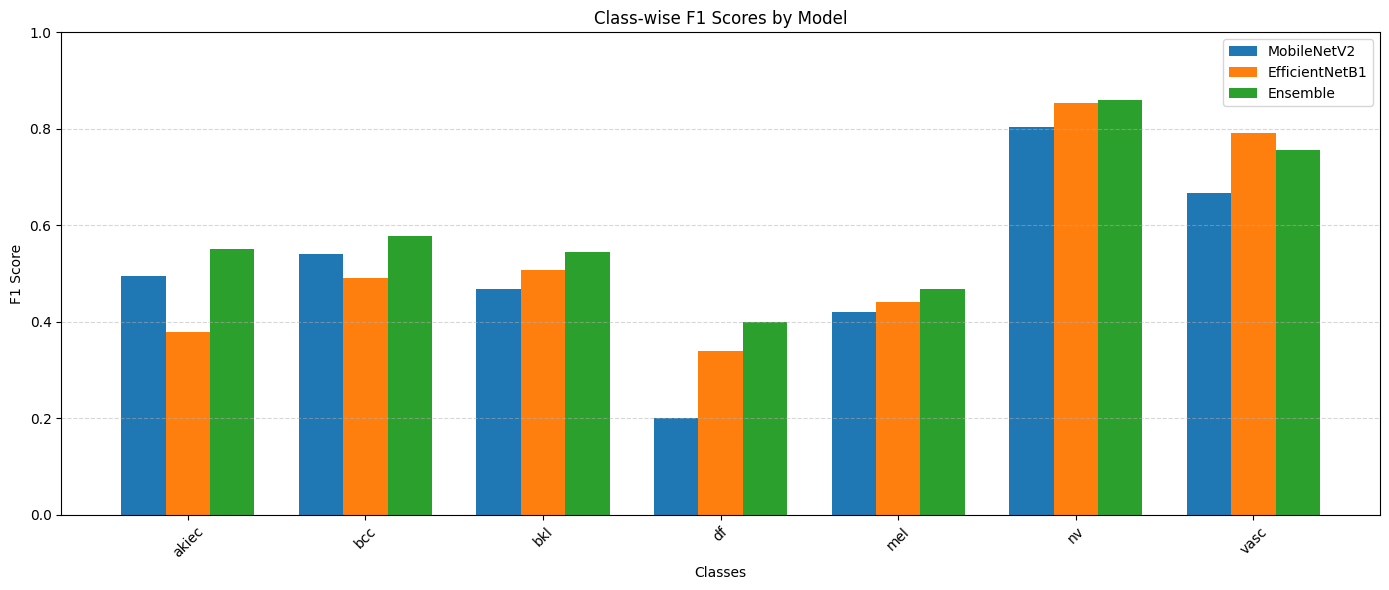

In [145]:
# Compute class-wise F1 scores for each model
mobilenet_f1 = f1_score(y_true, mobilenet_preds, average=None)
efficientnet_f1 = f1_score(y_true, efficientnet_preds, average=None)
ensemble_f1 = f1_score(y_true, ensemble_preds, average=None)

x = np.arange(len(class_names))  # the label locations
width = 0.25  # width of the bars

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(x - width, mobilenet_f1, width, label='MobileNetV2')
plt.bar(x, efficientnet_f1, width, label='EfficientNetB1')
plt.bar(x + width, ensemble_f1, width, label='Ensemble')

plt.ylabel('F1 Score')
plt.xlabel('Classes')
plt.title('Class-wise F1 Scores by Model')
plt.xticks(x, class_names, rotation=45)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Using Ensemble with varying weights of the two model**

Macro F1: 0.6069
Micro F1: 0.7365
Weighted F1: 0.7557


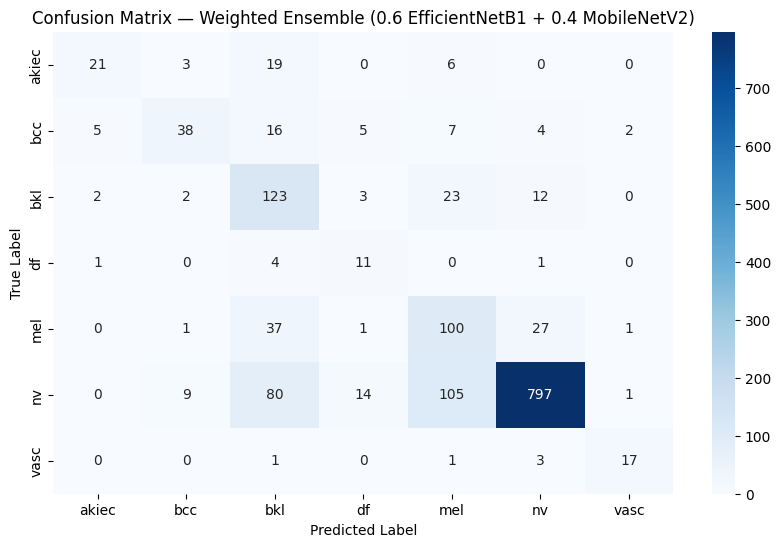

<Figure size 1000x500 with 0 Axes>

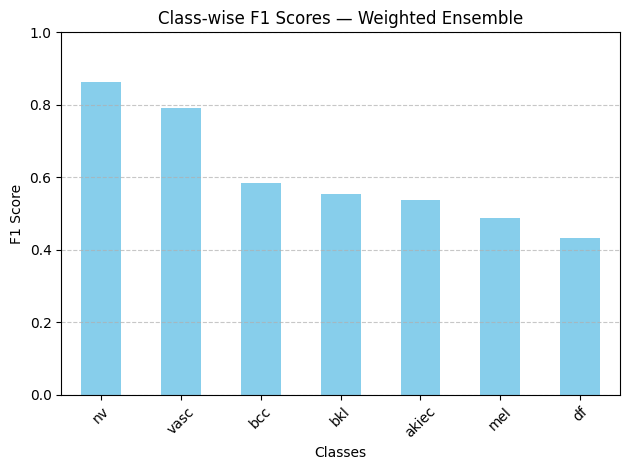

In [146]:
#Define weeights
# Define weights
w_eff = 0.6
w_mob = 0.4

# Predict using both models 
ensemble_preds_weighted = []
y_true = []

for images, labels in test_ds:
    mobilenet_probs = mobilenet_model.predict(images, verbose=0)
    efficientnet_probs = efficientnet_model.predict(images, verbose=0)

    combined_probs = w_mob * mobilenet_probs + w_eff * efficientnet_probs
    preds = np.argmax(combined_probs, axis=1)
    
    ensemble_preds_weighted.extend(preds)
    y_true.extend(labels.numpy())  



ensemble_preds_weighted = np.array(ensemble_preds_weighted)
y_true = np.array(y_true)

# Classification Report & F1 Scores
report = classification_report(y_true, ensemble_preds_weighted, output_dict=True)
f1_macro = f1_score(y_true, ensemble_preds_weighted, average='macro')
f1_micro = f1_score(y_true, ensemble_preds_weighted, average='micro')
f1_weighted = f1_score(y_true, ensemble_preds_weighted, average='weighted')

print(f"Macro F1: {f1_macro:.4f}")
print(f"Micro F1: {f1_micro:.4f}")
print(f"Weighted F1: {f1_weighted:.4f}")

# Confusion Matrix 
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
cm = confusion_matrix(y_true, ensemble_preds_weighted)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Weighted Ensemble (0.6 EfficientNetB1 + 0.4 MobileNetV2)")
plt.show()

# Per-Class F1 Scores 
# Create classification report using class indices as labels
report = classification_report(y_true, ensemble_preds_weighted, output_dict=True)

# Map index to class name (make sure class_names is defined in correct order)
index_to_class = {i: name for i, name in enumerate(class_names)}

# Extract per-class F1 using index keys ('0', '1', ...) and rename them to class names
f1_per_class = {
    index_to_class[int(cls)]: report[cls]['f1-score']
    for cls in report.keys() if cls.isdigit()
}

# Create DataFrame and plot
f1_class_df = pd.DataFrame.from_dict(f1_per_class, orient='index', columns=['F1 Score'])
f1_class_df = f1_class_df.sort_values(by='F1 Score', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
f1_class_df.plot(kind='bar', legend=False, color='skyblue')
plt.title('Class-wise F1 Scores — Weighted Ensemble')
plt.ylabel('F1 Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Macro F1: [0.5136334708917205, 0.5432750306070535, 0.5935859976126397, 0.6069393302732895]
Micro F1: [0.654690618762475, 0.709913506320692, 0.729208250166334, 0.7365269461077845]
Weighted F1: [0.691551228504235, 0.7293811279715259, 0.7498538956492337, 0.7556860335029959]


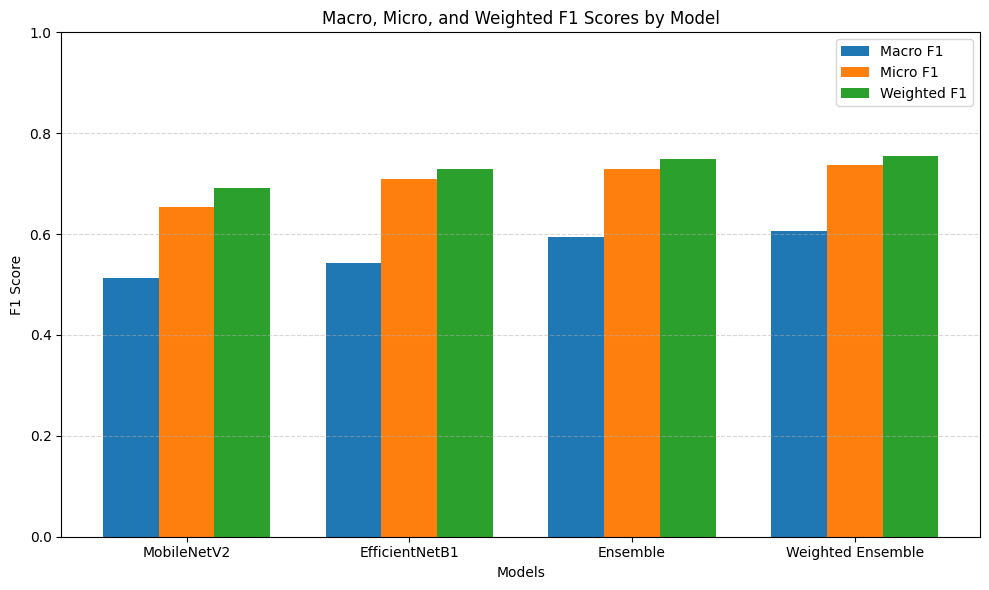

In [147]:
# Step 1: Initialize lists
mobilenet_preds = []
efficientnet_preds = []
ensemble_preds = []
ensemble_preds_weighted = []
y_true = []

# Step 2: Collect predictions
for images, labels in test_ds:
    m_probs = mobilenet_model.predict(images, verbose=0)
    e_probs = efficientnet_model.predict(images, verbose=0)

    # Individual predictions
    mobilenet_preds.extend(np.argmax(m_probs, axis=1))
    efficientnet_preds.extend(np.argmax(e_probs, axis=1))

    # Simple average ensemble
    avg_probs = (m_probs + e_probs) / 2.0
    ensemble_preds.extend(np.argmax(avg_probs, axis=1))

    # Weighted ensemble (EfficientNetB1: 0.6, MobileNetV2: 0.4)
    weighted_probs = (0.6 * e_probs + 0.4 * m_probs)
    ensemble_preds_weighted.extend(np.argmax(weighted_probs, axis=1))

    # True labels (one-hot to class index)
    y_true.extend(labels.numpy())


# Step 3: Convert to arrays
mobilenet_preds = np.array(mobilenet_preds)
efficientnet_preds = np.array(efficientnet_preds)
ensemble_preds = np.array(ensemble_preds)
ensemble_preds_weighted = np.array(ensemble_preds_weighted)
y_true = np.array(y_true)

# Step 4: Compute F1 Scores
macro_f1 = [
    f1_score(y_true, mobilenet_preds, average='macro'),
    f1_score(y_true, efficientnet_preds, average='macro'),
    f1_score(y_true, ensemble_preds, average='macro'),
    f1_score(y_true, ensemble_preds_weighted, average='macro'),
]

micro_f1 = [
    f1_score(y_true, mobilenet_preds, average='micro'),
    f1_score(y_true, efficientnet_preds, average='micro'),
    f1_score(y_true, ensemble_preds, average='micro'),
    f1_score(y_true, ensemble_preds_weighted, average='micro'),
]

weighted_f1 = [
    f1_score(y_true, mobilenet_preds, average='weighted'),
    f1_score(y_true, efficientnet_preds, average='weighted'),
    f1_score(y_true, ensemble_preds, average='weighted'),
    f1_score(y_true, ensemble_preds_weighted, average='weighted'),
]

print("Macro F1:", macro_f1)
print("Micro F1:", micro_f1)
print("Weighted F1:", weighted_f1)

# Step 5: Plot
labels = ['MobileNetV2', 'EfficientNetB1', 'Ensemble', 'Weighted Ensemble']
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, macro_f1, width=width, label='Macro F1')
plt.bar(x, micro_f1, width=width, label='Micro F1')
plt.bar(x + width, weighted_f1, width=width, label='Weighted F1')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Macro, Micro, and Weighted F1 Scores by Model')
plt.xticks(ticks=x, labels=labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [148]:
# Paths to your saved base models
mobilenet_path = "baseline_mobilenetv2_focal.keras"
efficientnet_path = "efficientnetb1_finetuned_best.keras"

# Common metadata
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
input_size = [224, 224]

#  Save Average Ensemble 
avg_dir = "ensemble_avg"
os.makedirs(avg_dir, exist_ok=True)

# Copy base models into this folder
shutil.copy(mobilenet_path, os.path.join(avg_dir, "mobilenet_model.keras"))
shutil.copy(efficientnet_path, os.path.join(avg_dir, "efficientnet_model.keras"))

# Save config
avg_config = {
    "ensemble_type": "average",
    "mobilenet_model_path": "mobilenet_model.keras",
    "efficientnet_model_path": "efficientnet_model.keras",
    "input_size": input_size,
    "class_names": class_names
}

with open(os.path.join(avg_dir, "config.json"), "w") as f:
    json.dump(avg_config, f, indent=4)

print(" Saved average ensemble config to:", avg_dir)


# Save Weighted Ensemble
weighted_dir = "ensemble_weighted"
os.makedirs(weighted_dir, exist_ok=True)

# Copy base models into this folder
shutil.copy(mobilenet_path, os.path.join(weighted_dir, "mobilenet_model.keras"))
shutil.copy(efficientnet_path, os.path.join(weighted_dir, "efficientnet_model.keras"))

# Save config
weighted_config = {
    "ensemble_type": "weighted_average",
    "mobilenet_model_path": "mobilenet_model.keras",
    "efficientnet_model_path": "efficientnet_model.keras",
    "mobilenet_weight": 0.4,
    "efficientnet_weight": 0.6,
    "input_size": input_size,
    "class_names": class_names
}

with open(os.path.join(weighted_dir, "config.json"), "w") as f:
    json.dump(weighted_config, f, indent=4)

print(" Saved weighted ensemble config to:", weighted_dir)

#We can use load_ensemble() functioin to load them later

 Saved average ensemble config to: ensemble_avg
 Saved weighted ensemble config to: ensemble_weighted


## Comparative Analysis

### Comparison of Model Performance

We evaluated three models to compare performance and improvement over the baseline:

1. **Main Model (Baseline CNN)**
2. **MobileNetV2 (Transfer Learning)**
3. **EfficientNetB1 (Advanced Transfer Learning)**

#### Evaluation Metrics Summary

| Metric           | Main Model | MobileNetV2 | EfficientNetB1 |
|------------------|------------|-------------|----------------|
| Accuracy         | 0.50       | 0.65        | **0.70**       |
| Macro F1         | 0.34       | 0.51        | **0.54**       |
| Weighted F1      | 0.55       | 0.69        | **0.72**       |
| Micro F1         | 0.50       | 0.65        | **0.70**       |

---

### Key Observations

- **Overall Improvement**: Both MobileNetV2 and EfficientNetB1 significantly outperformed the baseline model across all metrics, particularly in terms of accuracy and F1 scores.
  
- **MobileNetV2** brought major improvements:
  - Macro F1 jumped from **0.34 to 0.51**, showing better handling of underrepresented classes.
  - Accuracy improved from **0.50 to 0.65**.
  - Indicates that using pre-trained features helped generalize better on limited data.

- **EfficientNetB1** achieved the best overall performance:
  - Accuracy reached **0.70**, and Weighted F1 improved to **0.72**.
  - Most classes showed improved recall and F1, especially minority classes like `df` and `vasc`.

---

###  Setbacks and Challenges

- **Class Imbalance**: While macro F1 improved, some minority classes (e.g., `df`, `akiec`) still have low F1 scores across all models, though there's visible improvement with EfficientNetB1.
  
- **Precision-Recall Tradeoff**: For some classes (e.g., `akiec` in EfficientNetB1), high precision came at the cost of low recall, indicating the model was too conservative in predicting certain classes.

---

### Conclusion

The use of **transfer learning** (especially with EfficientNetB1) led to consistent and measurable improvements over the baseline CNN. The models benefited from:

- Pre-trained features on large datasets  
- Fine-tuning of higher layers  
- Hyperparameter optimization  
- Better data preprocessing

Further improvements may come from:

- Handling class imbalance (e.g., weighted loss, oversampling)  
- Tuning thresholds per class  
- Exploring ensemble methods
